# Joining CPDB geometries onto collapsed Checkbook NYC dataset

## Setup

In [145]:
import pandas as pd
import numpy as np
import re
import datetime
import time
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import ticker
import seaborn as sns
import os

In [146]:
checkbook = pd.read_csv('checkbook_nyc_groupby_capital_project_fy.csv')
cpdb = pd.read_csv('../data/cpdb/cpdb_projects.csv') # no geometries, just projects
print(checkbook.shape[0], cpdb.shape[0])

80932 12478


In [147]:
# get all the cpdb geometries file names
path = "../data/cpdb/"
cpdb_file_list = os.listdir(path)
cpdb_file_list.remove('cpdb_projects.csv')
cpdb_file_list.remove('.DS_Store')

## Initial work - Joining 2023 Checkbook NYC projects onto 2023 CPDB projects file, no geoms

In [148]:
cpdb_gdf_poly = gpd.read_file('../data/cpdb/cpdb_dcpattributes_poly_23/')
cpdb_gdf_pts = gpd.read_file('../data/cpdb/cpdb_dcpattributes_pts_23/')

In [149]:
# filter dataframe to include only projects from this fiscal year
checkbook_2023 = checkbook[checkbook['Fiscal year']==2023]

In [150]:
# left join on Checkbook NYC 2023 with CPDB (no geoms)
join_cpdb_checkbook_2023 = checkbook_2023.merge(cpdb, how='left', left_on='FMS ID', right_on='maprojid', indicator=True)
join_cpdb_checkbook_2023.drop('Unnamed: 0', axis=1, inplace=True)

In [151]:
# percent checkbook nyc projects that can be matched to CPDB rows (no geometries)
num_matches_no_geoms = join_cpdb_checkbook_2023[join_cpdb_checkbook_2023['_merge']=='both']
print(num_matches_no_geoms.shape[0]/checkbook_2023.shape[0])

0.5922073890096243


## Join all CPDB Geometries onto Checkbook NYC Projects

Using the collapsed Checkbook NYC dataset and a merged version of CPDB (spanning 2017-present), left joined CPDB onto Checkbook NYC and then reported the results. 

In [152]:
# define functions
def merge_all_cpdb_geoms(path, file_list):
    """
    input: path and list of file names
    output: GeoDataFrame
    """
    file_list = sorted(file_list, key=lambda x: int(re.search(r'\d+$',x).group()), reverse=True)

    gdf_list = []
    for f in file_list:
        gdf = gpd.read_file(path + f)
        gdf_list.append(gdf)

    all_cpdb_geoms = pd.concat(gdf_list)
    # deal with duplicates
    all_cpdb_geoms.drop_duplicates(subset='maprojid', keep='first', inplace=True, ignore_index=True)
    return all_cpdb_geoms

# joining all of Checkbook NYC onto all cpdb
def join_checkbook_geoms(df, cpdb_geoms):
    """
    input:
    df -> dataframe to be left joined onto, in this case checkbook nyc
    cpdb_geoms -> geodataframe to join onto df, contains all shape files 2017-2023
    output:
    gdf -> geodataframe of cpdb geometries left joined onto checkbook nyc
    """
    merged = df.merge(cpdb_geoms, how='left', left_on='FMS ID', right_on='maprojid', indicator=True) # left join so we can easily count how many projects did not map to a geometry
    ### may need to uncomment this later because it might break something 
    #merged.drop('Unnamed: 0', axis=1, inplace=True)
    gdf = gpd.GeoDataFrame(merged, geometry='geometry')
    return gdf

In [153]:
all_gdf = merge_all_cpdb_geoms(path, cpdb_file_list)

In [154]:
### potential extension
# why are there multiple geometries for some maprojids in CPDB? 
# could potentially add a column indicating year of CPDB build the geometry is pulled from, match that on FY for Checkbook NYC
print(all_gdf.shape[0])
print(all_gdf['maprojid'].unique().shape[0])

### take the latest geometry for now, but note that there are instances with many different geometries for the same maprojid 
all_gdf_groupby_maprojid = all_gdf.groupby('maprojid')['geometry'].nunique()
all_gdf_groupby_maprojid.mean()

all_gdf_groupby_maprojid.max()
all_gdf_groupby_maprojid[all_gdf_groupby_maprojid==7]

8042
8042


Series([], Name: geometry, dtype: int64)

In [155]:
gdf = join_checkbook_geoms(checkbook, all_gdf)

In [177]:
def describe_categories(gdf, category):
    """
    input: 
    gdf -> geodataframe
    category -> string (ITT vehicles or equipment, lump sum, fixed asset, or NULL)
    return: null 
    """
    if category=='None':
        cat_geoms = gdf[(gdf['_merge']=='both') & (gdf['typecatego'].isna())]
    else:
        cat_geoms = gdf[(gdf['_merge']=='both') & (gdf['typecatego']==category)]
    
    n = gdf.shape[0]
    m = cat_geoms.shape[0]

    print("Percent of Checkbook NYC projects that were joined to CPDB geometries and categorized as {}: {}".format(category, round((m/n)*100, 2)))
    print("Percent of total money captured by Checkbook NYC represented by joined projects categorized as {}: {}".format(category, round((sum(cat_geoms['Check Amount'])/sum(gdf['Check Amount']))*100,2)))
    return

def describe_geometries(gdf):
    geoms = gdf[gdf['_merge']=='both']
    n = gdf.shape[0]
    m = geoms.shape[0]

    print("Number of Checkbook NYC projects mapped to geometries: {}".format(m))
    print("Percent of Checkbook NYC projects mapped to geometries: {}".format(round((m/n)*100, 2)))
    print("Amount of money from Checkbook NYC projects mapped to geometries: {}".format(round(sum(geoms['Check Amount']), 2)))
    print("Percent of money from Checkbook NYC projects mapped to geometries: {}".format(round((sum(geoms['Check Amount'])/sum(gdf['Check Amount']))*100, 2)))
    return 

In [178]:
cats = ['Fixed Asset', 'ITT, Vehicles, and Equipment', 'Lump Sum', 'None']

for cat in cats:
    describe_categories(gdf, cat)

describe_geometries(gdf)

Percent of Checkbook NYC projects that were joined to CPDB geometries and categorized as Fixed Asset: 24.9
Percent of total money captured by Checkbook NYC represented by joined projects categorized as Fixed Asset: 13.66
Percent of Checkbook NYC projects that were joined to CPDB geometries and categorized as ITT, Vehicles, and Equipment: 2.39
Percent of total money captured by Checkbook NYC represented by joined projects categorized as ITT, Vehicles, and Equipment: 0.92
Percent of Checkbook NYC projects that were joined to CPDB geometries and categorized as Lump Sum: 2.53
Percent of total money captured by Checkbook NYC represented by joined projects categorized as Lump Sum: 1.87
Percent of Checkbook NYC projects that were joined to CPDB geometries and categorized as None: 7.02
Percent of total money captured by Checkbook NYC represented by joined projects categorized as None: 4.75
Number of Checkbook NYC projects mapped to geometries: 29813
Percent of Checkbook NYC projects mapped to 

In [158]:
geoms = gdf[gdf['_merge']=='both']
geoms.head(5)

,Unnamed: 0,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,...,projectid,descriptio,typecatego,geomsource,dataname,datasource,datadate,geometry,cartodb_id,_merge
52,52,New York Public Library,NaN,FTW4 (NYPL: FORT WASHINGTON (2535 WEST 179TH S),037LN18CAFTW002,11035.64,DO103520212006752,Multi-branch WiFi Access Point Refresh,400-037-M01,20230257727-1-DSB-EFT,...,LN18CAFTW,FORT WASHINGTON - Initial Outfitting (Carnegie...,Fixed Asset,Facilities database,NaN,NaN,NaN,POINT (-73.93385 40.84787),1164.0,both
53,53,New York Public Library,NaN,FTW5 (NYPL: FORT WASHINGTON (2535 WEST 179TH S),037LN18CAFTW002,21200.50,CT103520231410502,Thos. Moser Tables and Chairs,400-037-M01,20230330350-1-DSB-EFT,...,LN18CAFTW,FORT WASHINGTON - Initial Outfitting (Carnegie...,Fixed Asset,Facilities database,NaN,NaN,NaN,POINT (-73.93385 40.84787),1164.0,both
56,56,New York Public Library,NaN,"MEL2 (NYPL: MELROSE (910 MORRIS AVE, BX): INIT)",037LN18CAMEL002,14976.94,DO103520212006752,Multi-branch WiFi Access Point Refresh,400-037-X01,20230257727-1-DSB-EFT,...,LN18CAMEL,MELROSE - Initial Outfitting (Carnegie Branch),Fixed Asset,Facilities database,NaN,NaN,NaN,POINT (-73.91758 40.82658),527.0,both
57,57,New York Public Library,NaN,"MEL3 (NYPL: MELROSE (910 MORRIS AVE, BX): INIT)",037LN18CAMEL001,20563.50,CT103520231410502,Thos. Moser Tables and Chairs,400-037-008,20230330350-1-DSB-EFT,...,LN18CAMEL,MELROSE - Initial Outfitting (Carnegie Branch),Fixed Asset,Facilities database,NaN,NaN,NaN,POINT (-73.91758 40.82658),527.0,both
58,58,New York Public Library,NaN,"PTR1 (NYPL: PORT RICHMOND (75 BENNETT ST, SI):)",037LN18CAPTR003,10247.38,DO103520212006752,Multi-branch WiFi Access Point Refresh,400-037-R01,20230257727-1-DSB-EFT,...,LN18CAPTR,PORT RICHMOND - Initial Outfitting (Carnegie B...,Fixed Asset,Facilities database,NaN,NaN,NaN,POINT (-74.13110 40.63758),990.0,both


# CPDB category vs. Checkbook NYC category
 After running categorization process on Checkbook NYC (`Budget Code` and `Contract Purpose` columnns), are there significant differences in the category assignments between CPDB and Checkbook NYC? 

## Joining onto Checkbook NYC (with categories assigned by Budget Code)

In [159]:
## Joining onto Checkbook NYC (with categories assigned by Budget Code)

checkbook_categorized = pd.read_csv('../data/checkbook_categories/CategorizationCheckbook.csv')


In [160]:
# cleaning duplicate cols
checkbook_categorized.columns

Index(['Agency', 'Associated Prime Vendor', 'Budget Code', 'Capital Project',
       'Check Amount', 'Contract ID', 'Contract Purpose', 'Department',
       'Document ID', 'Emerging Business', 'Expense Category', 'Fiscal year',
       'Industry', 'M/WBE Category', 'Payee Name', 'Spending Category',
       'Sub Contract Reference ID', 'Sub Vendor', 'Woman Owned Business',
       'FMS ID', 'BudgetCode_Categories', 'Contracts_Categories'],
      dtype='object')

In [161]:
# join merged cpdb onto both version of checkbook nyc 
categorized_gdf = join_checkbook_geoms(checkbook_categorized, all_gdf)

### save to csv
#categorized_gdf.to_csv('../data/checkbooknyc_geometries_with_cats.csv')

# Visualizations

Ideas:

- Pie charts: 
    - Percent of projects mapped 
    - Percent of money mapped
- Bar charts:
    - Number of projects with geometries by category
    - Amount of money with eometries by category
- Maps: 
    - Checkbook NYC geometries vs. all CPDB geometries
    - Checkbook NYC geometries vs. all CPDB geometries, broken down by category

## Pie charts

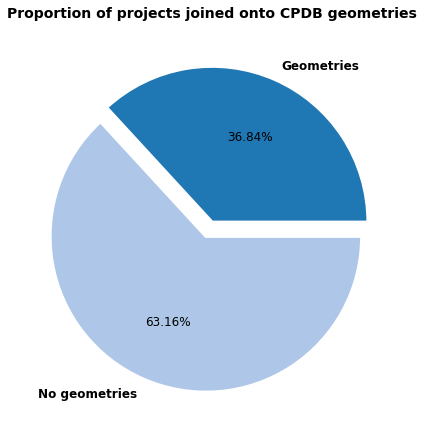

In [162]:
# --- PERCENT OF CHECKBOOK NYC PROJECTS WITH GEOMETRIES
fig, ax = plt.subplots(figsize=(6,6))

n = gdf.shape[0]
m = geoms.shape[0]
data = [(m/n), (1-(m/n))]

labels = ['Geometries', 'No geometries']
patches, texts, pcts = ax.pie(data, labels=labels, colors=sns.color_palette('tab20'), autopct='%.2f%%',
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'large'},
       startangle=360,
       explode=(0, 0.1))
ax.set_title('Proportion of projects joined onto CPDB geometries',  fontsize = 14, fontweight = 'bold', color = 'black', pad = 10 )
plt.setp(pcts, color='black', fontweight=400)
plt.setp(texts, fontweight=600)
plt.tight_layout()
plt.show()
#fig.savefig('percent_geoms_pie.png', facecolor='white', transparent=False, bbox_inches='tight')

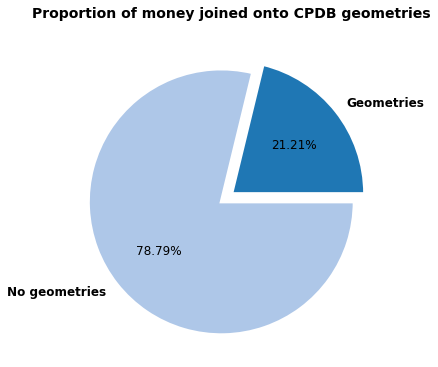

In [163]:
# --- PERCENT OF MONEY FROM CHECKBOOK NYC WITH GEOMETRIES

fig, ax = plt.subplots(figsize=(6,6))

n = sum(gdf['Check Amount'])
m = sum(geoms['Check Amount'])
data = [(m/n), (1-(m/n))]

labels = ['Geometries', 'No geometries']
patches, texts, pcts = ax.pie(data, labels=labels, colors=sns.color_palette('tab20'), autopct='%.2f%%',
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'large'},
       startangle=360,
       explode=(0, 0.1))
ax.set_title('Proportion of money joined onto CPDB geometries',  fontsize = 14, fontweight = 'bold', color = 'black', pad = 10 )
plt.setp(pcts, color='black', fontweight=400)
plt.setp(texts, fontweight=600)
plt.tight_layout()
plt.show()
#fig.savefig('percent_money_pie.png', facecolor='white', transparent=False, bbox_inches='tight')

## Bar charts

In [164]:
category_order_1 = ['Fixed Asset', 'Lump Sum', 'ITT, Vehicles, and Equipment', 'None']
category_order_2 = ['Fixed Asset', 'ITT, Vehicles, and Equipment', 'Lump Sum', 'None']

category_colors = {
    'Fixed Asset': 'indianred', 
    'Lump Sum': 'gold', 
    'ITT, Vehicles, and Equipment': 'cornflowerblue', 
    'None': 'lightsteelblue'
}

# --- NUMBER OF PROJECTS WITH GEOMETRY BY CATEGORY
geoms['typecatego'] = geoms['typecatego'].fillna('None')
cat_counts = geoms.groupby('typecatego')['maprojid'].count().reset_index()
cat_counts.columns = ['Category', 'Count']
cat_counts['Category Order'] = pd.Categorical(cat_counts['Category'], categories=category_order_1, ordered=True).codes
cat_counts = cat_counts.sort_values('Category Order')
cat_counts['Color'] = cat_counts['Category'].map(category_colors)

#cat_counts.sort_values(by='Count',ascending=False, inplace=True)

# --- AMOUNT OF MONEY WITH GEOMETRY BY CATEGORY
cat_check_sum = geoms.groupby('typecatego')['Check Amount'].sum().reset_index()
cat_check_sum.columns = ['Category', "Sum of Check Amounts"]
#cat_check_sum.sort_values(by="Sum of Check Amounts",ascending=False, inplace=True)
cat_check_sum['Category Order'] = pd.Categorical(cat_counts['Category'], categories=category_order_2, ordered=True).codes
cat_check_sum = cat_check_sum.sort_values('Category Order')
cat_check_sum['Color'] = cat_check_sum['Category'].map(category_colors)

cat_counts

/Users/alexandrathursland/opt/anaconda3/envs/dcp/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Category,Count,Category Order,Color
0,Fixed Asset,20155,0,indianred
2,Lump Sum,2045,1,gold
1,"ITT, Vehicles, and Equipment",1933,2,cornflowerblue
3,None,5680,3,lightsteelblue


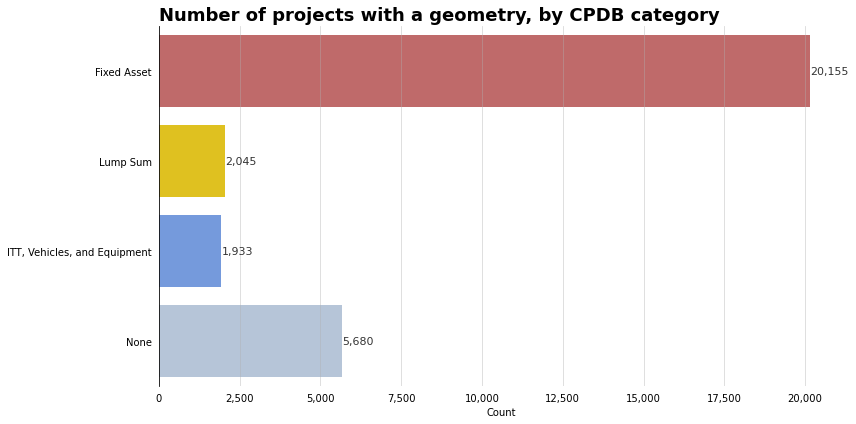

In [175]:
# --- Number of Checkbook NYC projects with a geometry, by category --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
ax = sns.barplot(data=cat_counts, y='Category', x='Count', ax=ax, palette = cat_counts['Color'], orient='h')

for p in ax.patches:
    width = p.get_width()
    label = f"{int(width):,}"
    x_pos = width + 5 
    y_pos = p.get_y() + p.get_height() / 2
    ax.annotate(label, (x_pos, y_pos), fontsize=11, fontweight='light', alpha=0.8, color='black', ha='left', va='center')

# tick marks and 0-line
sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Number of projects with a geometry, by CPDB category", fontsize=18, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("")
ax.set_xlabel("Count")
plt.tight_layout( h_pad=1 )

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

fig.savefig('geoms_by_cat_bar.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

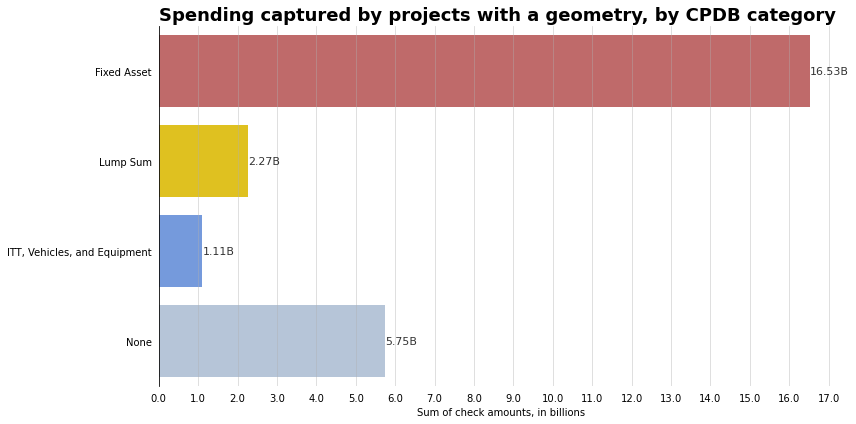

In [176]:
# --- Money from Checkbook NYC projects with a geometry, by category --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
ax = sns.barplot(data=cat_check_sum, y='Category', x='Sum of Check Amounts', ax=ax, palette = cat_check_sum['Color'], orient='h')

for p in ax.patches:
    width = p.get_width()
    label = f"{width / 1e9:.2f}B"
    x_pos = width + 5 
    y_pos = p.get_y() + p.get_height() / 2
    ax.annotate(label, (x_pos, y_pos), fontsize=11, fontweight='light', alpha=0.8, color='black', ha='left', va='center')

# tick marks and 0-line
sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Spending captured by projects with a geometry, by CPDB category", fontsize=18, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("")
ax.set_xlabel("Sum of check amounts, in billions")
plt.tight_layout( h_pad=1 )

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1e9))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1e9:.1f}"))

fig.savefig('geoms_by_cat_money_bar.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

## Maps

<Axes: >

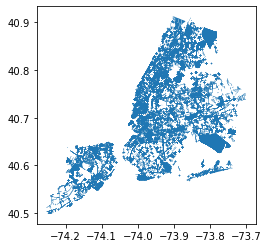

In [167]:
# visualize mapped geometries
nyc = gpd.read_file(geodatasets.get_path('nybb'))
# geoms.plot(cmap = 'tab20', column = 'Agency', markersize=0.1)
xmin, ymin, xmax, ymax = -74.219513, 40.547200,-73.770447,40.893792
geoms_bounded = geoms.cx[xmin:xmax, ymin:ymax]

geoms_bounded.plot(markersize=0.1)

In [168]:
invalid_geoms = geoms[~geoms['geometry'].is_valid]

invalid_geoms

,Unnamed: 0,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,...,projectid,descriptio,typecatego,geomsource,dataname,datasource,datadate,geometry,cartodb_id,_merge
68487,68487,Department of Cultural Affairs,NaN,BBGV (BROOKLYN BOTANIC GARDEN: PURCHASE DUMP T),850PV236-VEH001,64621.0,CT185020111404187,Maintenance vehicles,400-126-D06,20120037898-1-DSB-EFT,...,PV236-VEH,BBG - Brooklyn Botanic Garden - vehicular equi...,"ITT, Vehicles, and Equipment",AD Sprint,NaN,NaN,NaN,"POLYGON ((-73.96536 40.67215, -73.96463 40.671...",1379.0,both


### Summary of findings